# Real Datasets

experiments on various real-world datasets with different characteristics


In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo
from src.experiments import run_exact_proj_svgp, run_multiple_seeds, run_d_m_sweep_with_frontier
from src.config import TrainCfg, SVGPcfg
from src.kernels import SM_kernel, stable_rbf_kernel, stable_matern_kernel, stable_periodic_kernel


## Sunspots Dataset


In [5]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
df = df.dropna()

# y: normalised as in your snippet
y_all = df.iloc[:, 0].to_numpy(dtype=np.float32)
y_all = (y_all - np.mean(y_all)) / np.mean(y_all)

# x: map time to [0, 100] (float32)
t0 = df.index[0]
x_raw = ((df.index - t0).total_seconds().astype('float32') / 86_400.0)  # days since start
x_raw = np.array(x_raw)
x_min, x_max = x_raw.min(), x_raw.max()
x_all = 100.0 * (x_raw - x_min) / (x_max - x_min)  # [0, 100]

rng = np.random.default_rng(0)
perm = rng.permutation(len(x_all))
x_all = x_all[perm]
y_all = y_all[perm]

N = len(df)
n_train = int(0.80 * N)

x_train_np = x_all[:n_train].astype(np.float32)
y_train_np = y_all[:n_train].astype(np.float32)
x_test_np  = x_all[n_train:].astype(np.float32)
y_test_np  = y_all[n_train:].astype(np.float32)

# torch tensors (column vectors for GPs)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_train = torch.from_numpy(x_train_np).unsqueeze(-1).to(device)  # [N_train, 1]
y_train = torch.from_numpy(y_train_np).unsqueeze(-1).view(-1).to(device)  # [N_train, 1]
x_test  = torch.from_numpy(x_test_np).unsqueeze(-1).to(device)   # [N_test, 1]
y_test  = torch.from_numpy(y_test_np).unsqueeze(-1).view(-1).to(device)   # [N_test, 1]

# a dense grid covering the whole range for smooth plots
x_plot = np.linspace(x_all.min(), x_all.max(), 1000).astype(np.float32)

print(f"train: {len(x_train)}, test: {len(x_test)}")


train: 2256, test: 564



running exact GP training | iters=500 lr=0.005 lbfgs=False jitter=0.0001
[exact] iter=0000 loss=0.646244 Delta=inf ||grad||=7.86e-01
noise=0.171 |raw_noise|grad=0.2015140950679779
[exact] iter=0100 loss=0.413037 Delta=5.41e-03 ||grad||=3.20e-01
noise=0.109 |raw_noise|grad=0.17115113139152527
[exact] iter=0200 loss=0.305101 Delta=1.57e-03 ||grad||=2.08e-01
noise=0.0726 |raw_noise|grad=0.13155235350131989
[exact] iter=0300 loss=0.249419 Delta=1.34e-03 ||grad||=1.76e-01
noise=0.05 |raw_noise|grad=0.12078819423913956
[exact] iter=0400 loss=0.193649 Delta=3.72e-03 ||grad||=1.87e-01
noise=0.0335 |raw_noise|grad=0.1276596188545227
[exact] early stop @ 474
[exact] done | time=62.60s best_loss=0.178762

running spherical GP training | iters=500 lr=0.005 d=300 jitter=0.0001
[proj ] iter=0000 loss=1.270874 Delta=inf ||grad||=1.36e-01
noise=0.171 |raw_noise|grad=0.02952069602906704
[proj] early stop @ 86
[proj ] done | time=9.57s best_loss=1.253297

running SVGP training | steps=200 inducing poin

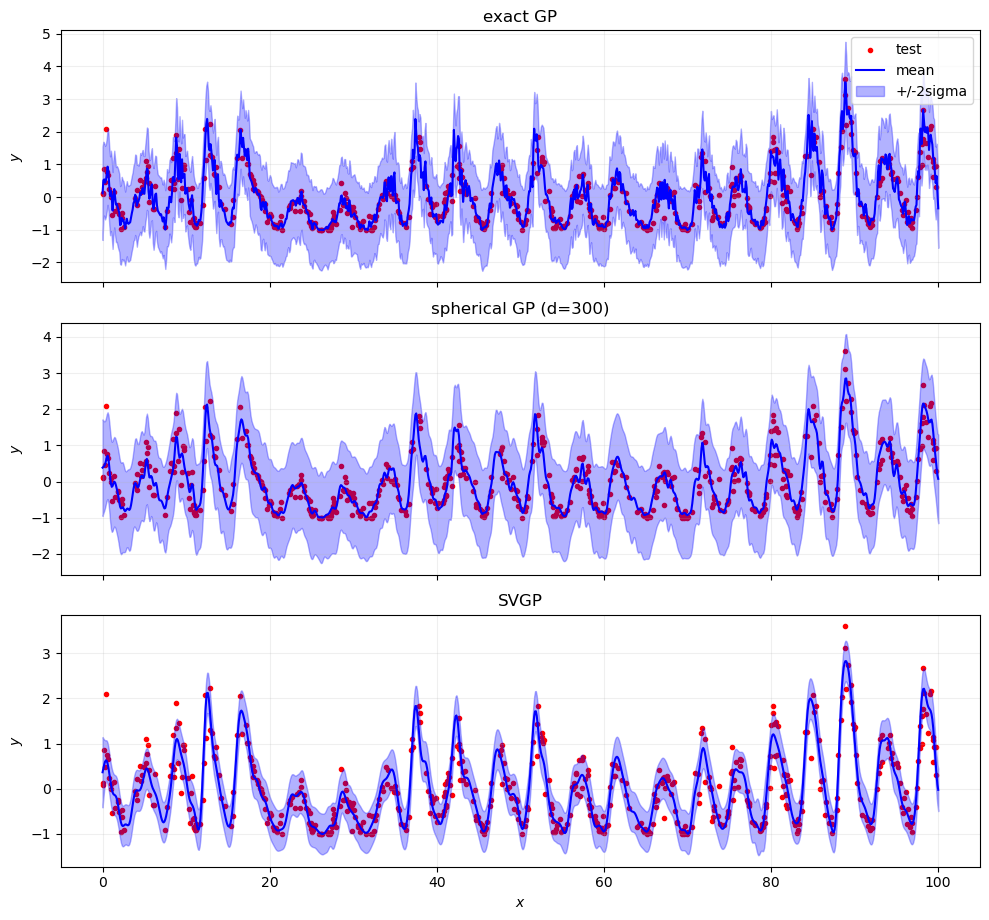

In [6]:
torch.manual_seed(2)
np.random.seed(2)

d_proj = 300          
num_mixtures = 2
kernel_exact = kernel_proj = kernel_svgp = None

res_exact, res_proj, res_svgp = run_exact_proj_svgp(
    x_train, y_train, x_test, y_test,
    x_plot=x_plot,
    d_proj=d_proj,
    num_mixtures=num_mixtures,
    cfg=TrainCfg(verbose=True, use_lbfgs=False, max_iter=500, loss_tol=1e-6,
    grad_tol=1e-4, patience=60, lr=0.005, mean_cfg="constant", noise_init=0.2),
    svgp_cfg=SVGPcfg(verbose=True,
                        m_inducing=256,
                        batch_size=512,
                        steps=200,
                        lr_hyp=1e-2,
                        lr_ngd=0.05,
                        patience=50, mean_cfg="constant"),
    kernel_exact=kernel_exact,
    kernel_proj=kernel_proj,
    kernel_svgp=kernel_svgp,
    add_svgp=True, keep_exact=True,
    # savepath='../results/sunspots.png'
)


### Multiple seeds

In [7]:
d_proj = 300          
num_mixtures = 2
kernel_exact = kernel_proj = kernel_svgp = None

results_sunspots = run_multiple_seeds(x_train, y_train, x_test, y_test, k=5, d_proj=d_proj, num_mixtures=2,
    kernel_exact=kernel_exact, kernel_proj=kernel_proj, kernel_svgp=kernel_svgp, keep_exact=True, add_svgp=True,
    cfg=TrainCfg(verbose=False, max_iter=800, loss_tol=1e-6,
                grad_tol=1e-4, patience=60, lr=0.005, mean_cfg="constant"),
    svgp_cfg=SVGPcfg(verbose=False, 
                        batch_size=512,
                        steps=200,
                        lr_hyp=1e-2,
                        lr_ngd=0.05,
                        patience=50, mean_cfg="constant"))

Running 5 seeds: 100%|██████████| 5/5 [04:52<00:00, 58.41s/it]


=== Summary of 5 runs ===
Base seed: 0
Projection dimension: 300
Number of mixtures: 2
Multi-scale: False
Exact GP included: True
SVGP included: True

=== Metrics Summary ===
spherical_RMSE: 0.2854 +/- 0.0031
spherical_NLPD: 0.3592 +/- 0.0277
spherical_COV95: 99.1844 +/- 0.2022
spherical_time: 12.6645 +/- 7.5878
exact_RMSE: 0.3063 +/- 0.0028
exact_NLPD: 0.7488 +/- 0.0320
exact_COV95: 99.8582 +/- 0.0793
exact_time: 34.4660 +/- 9.4696
SVGP_RMSE: 0.2955 +/- 0.0002
SVGP_NLPD: 0.2885 +/- 0.0011
SVGP_COV95: 87.5532 +/- 0.1483
SVGP_time: 10.9902 +/- 0.5637


## Bike sharing

In [8]:
bike_sharing = fetch_ucirepo(id=275) 
  
# data (as pandas dataframes) 
X = bike_sharing.data.features 
y = bike_sharing.data.targets 

# plt.plot(X.iloc[:,0], y, ".")
print(f"Original data shape: {X.shape}")

X = X.iloc[:, :].copy()
y = y.iloc[:, :].copy()

# Handle date columns - convert to datetime and extract useful features
if 'dteday' in X.columns:
    X['dteday'] = pd.to_datetime(X['dteday'])
    X['year'] = X['dteday'].dt.year
    X['month'] = X['dteday'].dt.month
    X['day'] = X['dteday'].dt.day
    X['dayofweek'] = X['dteday'].dt.dayofweek
    # Drop the original date column
    X = X.drop(columns=['dteday'])

# Select only numeric columns to avoid any remaining string issues
X_numeric = X.select_dtypes(include=[np.number])

# Convert to numpy arrays
X_np = X_numeric.to_numpy(dtype=np.float32)
y_np = y.iloc[:, 0].to_numpy(dtype=np.float32)  # Take first target column

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(X_np, y_np, test_size=0.2, random_state=0)

x_scaler = StandardScaler().fit(X_tr)
X_tr_s = x_scaler.transform(X_tr).astype(np.float32)
X_te_s = x_scaler.transform(X_te).astype(np.float32)

y_scaler = StandardScaler().fit(y_tr.reshape(-1, 1))
y_tr_s = y_scaler.transform(y_tr.reshape(-1, 1)).astype(np.float32).ravel()
y_te_s = y_scaler.transform(y_te.reshape(-1, 1)).astype(np.float32).ravel()

# Convert to torch tensors
x_train_t = torch.tensor(X_tr_s, dtype=torch.float32)
y_train_t = torch.tensor(y_tr_s, dtype=torch.float32)
x_test_t = torch.tensor(X_te_s, dtype=torch.float32)
y_test_t = torch.tensor(y_te_s, dtype=torch.float32)


Original data shape: (17379, 13)


In [3]:
torch.manual_seed(0)
np.random.seed(0)

d_proj = 500

kernel_proj = kernel_svgp = stable_matern_kernel(1, 2.5)

svgp_cfg_bike = SVGPcfg(
    verbose=False,
    m_inducing=512,
    batch_size=256,
    steps=200,
    lr_hyp=5e-3,
    lr_ngd=0.02,
    patience=75,
    eval_every=100,
    print_every=100,
    init_hyps_data=False,
    mean_cfg="zero"
)
svgp_cfg_bike2 = SVGPcfg(verbose=False, 
                        batch_size=512,
                        m_inducing=512,
                        steps=200,
                        lr_hyp=1e-2,
                        lr_ngd=0.05,
                        patience=50, mean_cfg="zero")

_, _, _ = run_exact_proj_svgp(
    x_train_t, y_train_t,
    x_test_t, y_test_t,
    d_proj=d_proj,
    kernel_proj=kernel_proj,
    kernel_svgp=kernel_svgp,
    keep_exact=False,
    add_svgp=True,
    cfg=TrainCfg(verbose=True, max_iter=800, loss_tol=1e-6,
                grad_tol=1e-4, patience=60, lr=0.05),
    svgp_cfg=svgp_cfg_bike2)


running spherical GP training | iters=800 lr=0.05 d=500 jitter=0.0001
[proj ] iter=0000 loss=1.400940 Delta=inf ||grad||=7.47e-02
noise=0.1 |raw_noise|grad=0.01184745505452156
[proj] early stop @ 82
[proj ] done | time=125.22s best_loss=1.391633


/Users/arkin/anaconda3/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:646.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


            GPyTorch (spherical) GPyTorch (SVGP)
lengthscale        [[1.9941697]]   [[3.4264011]]
outputscale             0.932726        0.244661
noise_var               0.104567        0.400001
             spherical        SVGP
RMSE_test     0.542120    0.620040
R2_test       0.711347    0.622326
NLPD_test     0.927176    0.950417
COV95_test   96.461450   94.476410
PIW95_test    2.948168    2.577282
time_sec    125.224756  198.662528
no plotting


### Multiple seeds

In [9]:
kernel_exact = kernel_proj = kernel_svgp = stable_rbf_kernel(2)
d_proj = 300

svgp_cfg_bike = SVGPcfg(
    verbose=False,
    m_inducing=512,
    batch_size=256,
    steps=200,
    lr_hyp=1e-2,
    lr_ngd=0.05,
    patience=50,
    eval_every=100,
    print_every=100,
    init_hyps_data=False,
    mean_cfg="zero"
)
results_bike = run_multiple_seeds(x_train_t, y_train_t, x_test_t, y_test_t, k=5, d_proj=d_proj,
    kernel_proj=kernel_proj, kernel_svgp=kernel_svgp, keep_exact=False, add_svgp=True,
    cfg=TrainCfg(verbose=False, max_iter=800, loss_tol=1e-6,
                grad_tol=1e-4, patience=60, lr=0.05),
    svgp_cfg=svgp_cfg_bike)

Running 5 seeds: 100%|██████████| 5/5 [24:04<00:00, 288.87s/it]


=== Summary of 5 runs ===
Base seed: 0
Projection dimension: 300
Number of mixtures: 1
Multi-scale: False
Exact GP included: False
SVGP included: True

=== Metrics Summary ===
spherical_RMSE: 0.5624 +/- 0.0022
spherical_NLPD: 1.0182 +/- 0.0377
spherical_COV95: 93.0207 +/- 2.8694
spherical_time: 87.5982 +/- 38.7832
SVGP_RMSE: 0.6280 +/- 0.0001
SVGP_NLPD: 0.9623 +/- 0.0002
SVGP_COV95: 94.7296 +/- 0.0427
SVGP_time: 191.9303 +/- 5.2492


## CASP Protein Tertiary Structure


In [2]:
try:
    df_casp = pd.read_csv('../data/CASP.csv')
    df_casp = df_casp.iloc[:24000].copy()
    print(f"loaded CASP data: {df_casp.shape}")
    
    y_series = df_casp["RMSD"]
    X_df = df_casp.drop(columns=["RMSD"])
    
    X_df = X_df.select_dtypes(include=[np.number]).copy()  # just numeric columns
    
    # train/test split
    X_train_df, X_test_df, y_train_np, y_test_np = train_test_split(
        X_df.values, y_series.values.astype(np.float32),
        test_size=0.2, random_state=0
    )
    
    # standardise features and target
    x_scaler = StandardScaler().fit(X_train_df)
    X_train = x_scaler.transform(X_train_df).astype(np.float32)
    X_test  = x_scaler.transform(X_test_df).astype(np.float32)
    
    y_scaler = StandardScaler().fit(y_train_np.reshape(-1, 1))
    y_train = y_scaler.transform(y_train_np.reshape(-1,1)).astype(np.float32).ravel()
    y_test  = y_scaler.transform(y_test_np.reshape(-1,1)).astype(np.float32).ravel()
    
    # downsample if too large
    N_exact = X_train.shape[0]
    idx_exact = np.random.default_rng(0).choice(X_train.shape[0], size=N_exact, replace=False)
    X_train_exact = X_train[idx_exact]
    y_train_exact = y_train[idx_exact]
    
    print(f"using {N_exact} samples out of {len(X_train)}")
    print(f"features: {X_df.shape[1]}")
    
except FileNotFoundError:
    print("CASP.csv not found in data directory - skipping this dataset")

# torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train_exact_t = torch.tensor(X_train_exact, dtype=torch.float32, device=device)
y_train_exact_t = torch.tensor(y_train_exact, dtype=torch.float32, device=device)
x_test_t        = torch.tensor(X_test,        dtype=torch.float32, device=device)
y_test_t        = torch.tensor(y_test,        dtype=torch.float32, device=device)


loaded CASP data: (24000, 10)
using 19200 samples out of 19200
features: 9


In [3]:
# run experiment if CASP data was loaded
torch.manual_seed(0)
np.random.seed(0)

kernel_exact = kernel_proj = kernel_svgp = stable_rbf_kernel(2)
d_proj = 5

svgp_cfg_casp = SVGPcfg(
    verbose=True,
    batch_size=512,
    m_inducing=512,
    steps=200,
    lr_hyp=1e-2,
    lr_ngd=0.05, patience=50, mean_cfg="zero")

res_exact, res_proj, res_svgp = run_exact_proj_svgp(
    x_train_exact_t, y_train_exact_t, x_test_t, y_test_t,
    d_proj=d_proj,
    cfg=TrainCfg(verbose=True, use_lbfgs=False, max_iter=200, loss_tol=1e-6,
    grad_tol=1e-4, patience=60, lr=0.05),
    svgp_cfg=svgp_cfg_casp,
    kernel_proj=kernel_proj,
    kernel_svgp=kernel_svgp,
    keep_exact=False,
    add_svgp=True,
)



running spherical GP training | iters=200 lr=0.05 d=5 jitter=0.0001
[proj ] iter=0000 loss=1.829735 Delta=inf ||grad||=3.81e-01
noise=0.01 |raw_noise|grad=0.003518899902701378
[proj ] iter=0100 loss=1.045983 Delta=7.76e-03 ||grad||=1.46e-01
noise=0.0132 |raw_noise|grad=0.0047278557904064655
[proj ] done | time=273.34s best_loss=0.578732

running SVGP training | steps=200 inducing points=512 lr=0.01


/Users/arkin/anaconda3/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:646.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


[SVGP] epoch  100/200: loss=1.149724, Delta_loss=4.03e-04, gradnorm=1.33e-01
[SVGP] epoch  200/200: loss=1.145469, Delta_loss=7.09e-04, gradnorm=1.04e-01
            GPyTorch (spherical) GPyTorch (SVGP)
lengthscale       [[0.81004864]]   [[1.0715157]]
outputscale             0.599005        0.371881
noise_var               0.013644        0.531766
             spherical        SVGP
RMSE_test     0.647202    0.707516
R2_test       0.573859    0.490612
NLPD_test     1.829863    1.074026
COV95_test   75.437500   95.437500
PIW95_test    1.506528    2.930876
time_sec    273.339023  193.960219
no plotting


In [4]:
kernel_exact = kernel_proj = kernel_svgp = stable_rbf_kernel(2)
d_proj = 200

svgp_cfg_casp = SVGPcfg(
    verbose=False,
    batch_size=512,
    m_inducing=512,
    steps=200,
    lr_hyp=1e-2,
    lr_ngd=0.05, patience=50, mean_cfg="zero")

results_casp = run_multiple_seeds(x_train_exact_t, y_train_exact_t, x_test_t, y_test_t, k=5, d_proj=d_proj,
    kernel_exact=kernel_exact, kernel_proj=kernel_proj, kernel_svgp=kernel_svgp, keep_exact=False, add_svgp=True,
    cfg=TrainCfg(verbose=False, max_iter=800, loss_tol=1e-6,
                grad_tol=1e-4, patience=60, lr=0.05),
    svgp_cfg=svgp_cfg_casp)

Running 5 seeds:   0%|          | 0/5 [00:00<?, ?it/s]

Running 5 seeds: 100%|██████████| 5/5 [41:58<00:00, 503.67s/it]


=== Summary of 5 runs ===
Base seed: 0
Projection dimension: 200
Number of mixtures: 1
Multi-scale: False
Exact GP included: False
SVGP included: True

=== Metrics Summary ===
spherical_RMSE: 0.6750 +/- 0.0160
spherical_NLPD: 1.1902 +/- 0.2977
spherical_COV95: 92.2542 +/- 8.4079
spherical_time: 271.6320 +/- 104.2192
SVGP_RMSE: 0.7075 +/- 0.0004
SVGP_NLPD: 1.0738 +/- 0.0006
SVGP_COV95: 95.4833 +/- 0.0401
SVGP_time: 214.1551 +/- 8.7431


# Unused

## Daily Min Temperatures


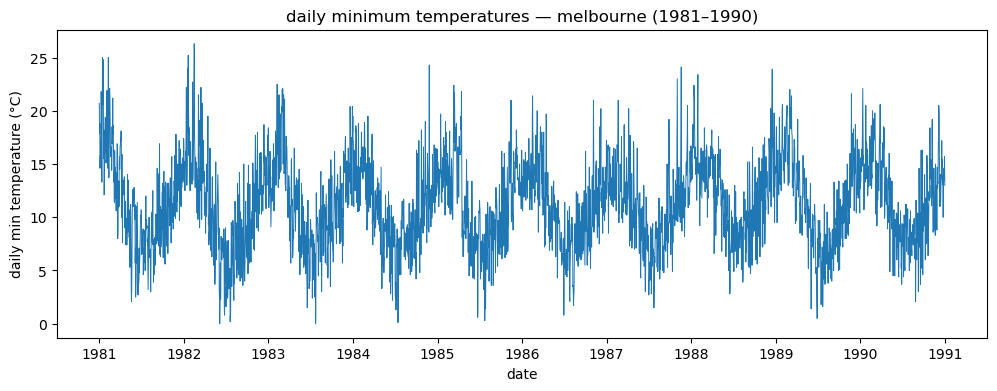

train points: 1200, test points: 300


In [ ]:
def load_daily_min_temps():
    """load daily minimum temperatures dataset"""
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
    df = pd.read_csv(url)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce", utc=False)
    df = df.dropna(subset=["Date", "Temp"]).sort_values("Date").reset_index(drop=True)
    df = df[np.isfinite(df["Temp"].values)]
    return df

df = load_daily_min_temps()

t0 = df["Date"].min()
x_all = (df["Date"] - t0).dt.days.values.astype(np.float32) / 365.25  # years since start
y_all = df["Temp"].values.astype(np.float32)

# quick sanity plot
plt.figure(figsize=(12, 4))
plt.plot(df["Date"].values, y_all, lw=0.7)
plt.xlabel("date")
plt.ylabel("daily min temperature (°C)")
plt.title("daily minimum temperatures — melbourne (1981–1990)")
plt.show()

TEST_FRAC = 0.2
rng = np.random.default_rng(0)

x_all = x_all[:1500]
y_all = y_all[:1500]

x_tr, x_te, y_tr, y_te = train_test_split(
    x_all, y_all, test_size=TEST_FRAC, random_state=0
)

print(f"train points: {len(x_tr)}, test points: {len(x_te)}")


running spherical GP training | iters=500 lr=0.02 d=400 jitter=0.0001
[proj ] iter=0000 loss=11.671301 Delta=inf ||grad||=3.04e+00
noise=0.1 |raw_noise|grad=0.23102828860282898
[proj ] iter=0100 loss=8.501874 Delta=2.08e-02 ||grad||=1.21e+00
noise=0.118 |raw_noise|grad=0.09887572377920151
[proj ] iter=0200 loss=7.240359 Delta=9.62e-03 ||grad||=7.22e-01
noise=0.132 |raw_noise|grad=0.0670013502240181
[proj ] iter=0300 loss=6.220773 Delta=4.81e-03 ||grad||=4.70e-01
noise=0.146 |raw_noise|grad=0.0434725396335125
[proj ] iter=0400 loss=5.942411 Delta=3.60e-03 ||grad||=3.84e-01
noise=0.159 |raw_noise|grad=0.03793524205684662
[proj] early stop @ 416
[proj ] done | time=15.13s best_loss=5.924438

running SVGP training | steps=500 inducing points=256 lr=0.003


/Users/arkin/anaconda3/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:646.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


[SVGP] epoch  200/500: loss=54.640734, Delta_loss=3.41e+00, gradnorm=4.65e+01
[SVGP] epoch  400/500: loss=31.253343, Delta_loss=2.23e-01, gradnorm=2.04e+01
[SVGP] epoch  500/500: loss=22.380680, Delta_loss=1.68e+00, gradnorm=1.30e+01
               GPyTorch (spherical)          GPyTorch (SVGP)
weight        [8.083653, 6.2780085]   [3.3686175, 1.6895422]
scale      [0.032772012, 1.6337951]  [0.04972127, 0.5108955]
mean               [0.0, 1.8660882]         [0.0, 1.0069197]
noise_var                  0.161348                 0.150222
            spherical       SVGP
RMSE_test    2.901505   2.900653
R2_test      0.579782   0.582280
NLPD_test   24.635725  27.250065
COV95_test  23.000000  23.333333
PIW95_test   1.624018   1.540196
time_sec    15.126843  14.292728


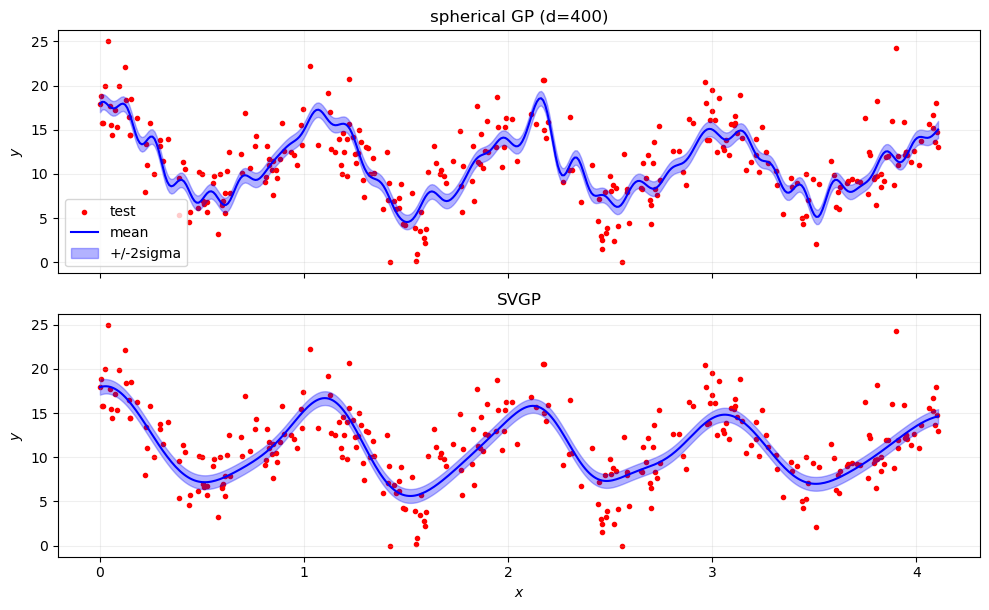

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

x_plot_t = np.linspace(x_all.min(), x_all.max(), 400).astype(np.float32)
x_train_t = torch.tensor(x_tr, dtype=torch.float32).unsqueeze(-1)
y_train_t = torch.tensor(y_tr, dtype=torch.float32)
x_test_t  = torch.tensor(x_te, dtype=torch.float32).unsqueeze(-1)
y_test_t  = torch.tensor(y_te, dtype=torch.float32)

kernel_exact = kernel_proj = kernel_svgp = stable_matern_kernel()
_,_,_ = run_exact_proj_svgp(
    x_train_t, y_train_t,
    x_test_t,  y_test_t,
    x_plot=x_plot_t,
    d_proj=400, svgp_cfg=SVGPcfg(m_inducing=256, steps=500),
    num_mixtures=2,
    add_svgp=True, keep_exact=False,
    savepath='../results/daily_min_temps.png'
)


## Power Plant Dataset


In [ ]:
# load power plant data
# ccpp = fetch_ucirepo(id=294)
# X_df = ccpp.data.features.rename(columns={
#     "AT": "AT", "V": "V", "AP": "AP", "RH": "RH"
# })
# y_df = ccpp.data.targets.rename(columns={"PE": "PE"})

ccpp = pd.read_csv('../data/CCPP.csv')
X_np = ccpp[["AT","V","AP","RH"]].to_numpy(dtype=np.float32)
y_np = ccpp["PE"].to_numpy(dtype=np.float32)

X_tr, X_te, y_tr, y_te = train_test_split(X_np, y_np, test_size=0.2, random_state=0)

x_scaler = StandardScaler().fit(X_tr)
X_tr_s = x_scaler.transform(X_tr).astype(np.float32)
X_te_s = x_scaler.transform(X_te).astype(np.float32)

y_tr_s = y_tr.astype(np.float32)
y_te_s = y_te.astype(np.float32)

# torch tensors
x_train_ccpp = torch.tensor(X_tr_s, dtype=torch.float32)
y_train_ccpp = torch.tensor(y_tr_s, dtype=torch.float32)
x_test_ccpp  = torch.tensor(X_te_s, dtype=torch.float32)
y_test_ccpp  = torch.tensor(y_te_s, dtype=torch.float32)

print(f"train: {len(x_train_ccpp)}, test: {len(x_test_ccpp)}")

# 1D plotting path in 4D space (vary AT, fix V/AP/RH at medians of train set)
medians = np.median(X_tr, axis=0)
at_lin   = np.linspace(X_np[:,0].min(), X_np[:,0].max(), 400).astype(np.float32)
x_plot_ccpp_orig = np.tile(medians[None,:], (len(at_lin),1))
x_plot_ccpp_orig[:,0] = at_lin
x_plot_ccpp = x_scaler.transform(x_plot_ccpp_orig).astype(np.float32)


train: 7654, test: 1914


In [ ]:
torch.manual_seed(0)
np.random.seed(0)

# kernel_exact = SM_kernel(2, 4)
# kernel_proj = SM_kernel(2, 4)
# kernel_svgp = SM_kernel(2, 4)

kernel_exact = kernel_proj = kernel_svgp = stable_rbf_kernel(2)
d_proj = 200

res_exact, res_proj, res_svgp = run_exact_proj_svgp(
    x_train_ccpp, y_train_ccpp, x_test_ccpp, y_test_ccpp,
    x_plot=x_plot_ccpp,
    d_proj=d_proj,
    num_mixtures=2,
    cfg=TrainCfg(verbose=True, use_lbfgs=False, max_iter=800, loss_tol=1e-6,
    grad_tol=1e-4, patience=60, lr=0.05),
    keep_exact=False,
    kernel_proj=kernel_proj,
    kernel_svgp=kernel_svgp,
    add_svgp=False,
    savepath='../results/CCPP.png'
)



running spherical GP training | iters=800 lr=0.05 d=200 jitter=0.0001
[proj ] iter=0000 loss=111063.976562 Delta=inf ||grad||=9.21e+04
noise=0.1 |raw_noise|grad=14382.369140625
[proj ] iter=0100 loss=26503.488281 Delta=1.37e+02 ||grad||=9.44e+03
noise=0.131 |raw_noise|grad=1599.5650634765625
[proj ] iter=0200 loss=18318.144531 Delta=4.72e+01 ||grad||=4.91e+03
noise=0.151 |raw_noise|grad=862.3161010742188
[proj ] iter=0300 loss=13884.366211 Delta=2.25e+01 ||grad||=3.11e+03
noise=0.168 |raw_noise|grad=625.6116333007812
[proj ] iter=0400 loss=12988.907227 Delta=1.75e+01 ||grad||=2.60e+03
noise=0.187 |raw_noise|grad=528.3692626953125
[proj ] iter=0500 loss=11602.340820 Delta=1.41e+01 ||grad||=2.22e+03
noise=0.206 |raw_noise|grad=467.90496826171875
[proj ] iter=0600 loss=10379.129883 Delta=9.42e+00 ||grad||=1.73e+03
noise=0.229 |raw_noise|grad=399.6582946777344
[proj ] iter=0700 loss=8687.285156 Delta=7.67e+00 ||grad||=1.51e+03
noise=0.253 |raw_noise|grad=370.5772705078125
[proj ] done | t